# Import Data
- Each row will represent a __single season's statistics__ from a single player.
- Most players will have multiple rows, as most played multiple seasons.

In [1]:
# helper.py
from helper import *

In [2]:
# get passing data
pass_df = load_pass_data()

# get rushing data
rush_df = load_rush_data()

# left join to ensure we keep all QBs with passing data, as this is more important than rushing data
df = pass_df.merge(rush_df, on=['player', 'year'], how='left')

# view duplicate players and unique QBs
df.duplicated().sum(), len(set(df.player))

(0, 299)

- No duplicate players.
- 299 unique NFL quarterbacks.

In [3]:
# view shape and nulls
show_shape_and_nulls(df)

Shape: (1398, 64)
Null values:


,player,team_name,player_game_count,pass_accuracy_percent,pass_aimed_passes,pass_attempts,pass_avg_depth_of_target,pass_avg_time_to_throw,pass_bats,pass_big_time_throws,pass_btt_rate,pass_completion_percent,pass_completions,pass_def_gen_pressures,pass_drop_rate,pass_dropbacks,pass_drops,pass_first_downs,pass_grades_hands_fumble,pass_grades_offense,pass_grades_pass,pass_hit_as_threw,pass_interceptions,pass_passing_snaps,pass_penalties,pass_pressure_to_sack_rate,pass_qb_rating,pass_sack_percent,pass_sacks,pass_scrambles,pass_spikes,pass_thrown_aways,pass_touchdowns,pass_turnover_worthy_plays,pass_twp_rate,pass_yards,pass_ypa,year,rush_attempts,rush_avoided_tackles,rush_breakaway_attempts,rush_breakaway_percent,rush_breakaway_yards,rush_designed_yards,rush_elu_recv_mtf,rush_elu_rush_mtf,rush_elu_yco,rush_elusive_rating,rush_explosive,rush_first_downs,rush_fumbles,rush_gap_attempts,rush_grades_offense_penalty,rush_grades_run,rush_longest,rush_run_plays,rush_scramble_yards,rush_total_touches,rush_touchdowns,rush_yards,rush_yards_after_contact,rush_yco_attempt,rush_ypa,rush_zone_attempts
0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,99,99,99,112,99,99,99,99,154,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99


- 1323 QB seasons.
- Very few nulls in the passing columns.
- Around 100 nulls in the rushing columns.
- These values will be imputed with 0.

In [4]:
# fill nulls with 0 and check
df = df.fillna(0)
df.isnull().sum().sum()

0

# Experience
- An "exp" feature will be added to represent the player's __years of experience__. For example, a rookie quarterback would have exp=0.
- 2006 QBs will need to be handeled uniquely, as most are not rookies.
- I manually found the experience of players in the 2006 season. This is found in the [helper file](./helper.py).

In [5]:
# initialize the exp column
df = init_exp_col(df)

# check
display(df[['player', 'exp', 'year']].head())
display(df[['player', 'exp', 'year']].tail())

,player,exp,year
0,Brett Favre,15.0,2006
1,Jon Kitna,10.0,2006
2,Marc Bulger,6.0,2006
3,Peyton Manning,8.0,2006
4,Drew Brees,5.0,2006


,player,exp,year
1393,Tyson Bagent,NaN,2024
1394,Nick Mullens,NaN,2024
1395,Clayton Tune,NaN,2024
1396,Kyle Trask,NaN,2024
1397,Kyle Allen,NaN,2024


- QBs who played in 2006 season have a valid "exp" value, non-2006 QBs have NaN value.

In [6]:
# group by index and fill experience values, drop multi-index
df = df.groupby('player').apply(fill_experience)

# Patrick Mahomes
df.query('player == "Patrick Mahomes"')[['player', 'year', 'exp']]

,player,year,exp
853,Patrick Mahomes,2017,0
875,Patrick Mahomes,2018,1
956,Patrick Mahomes,2019,2
1012,Patrick Mahomes,2020,3
1090,Patrick Mahomes,2021,4
1166,Patrick Mahomes,2022,5
1248,Patrick Mahomes,2023,6
1325,Patrick Mahomes,2024,7


- All players now have a corresponding experience for each of their seasons.

# Target Variable
- For each season __x__, the target is the grades_offense stat of season __x + 1__.

In [7]:
# ensure values are sorted properly
df = df.sort_values(by=['player', 'year']).reset_index(drop=True)

# add target col
df['target'] = df.groupby('player')['pass_grades_offense'].shift(-1)

# Mahomes
df.query('player == "Patrick Mahomes"')[['player', 'year', 'pass_grades_offense', 'target']]

,player,year,pass_grades_offense,target
1065,Patrick Mahomes,2017,72.6,93.2
1066,Patrick Mahomes,2018,93.2,83.6
1067,Patrick Mahomes,2019,83.6,91.4
1068,Patrick Mahomes,2020,91.4,77.1
1069,Patrick Mahomes,2021,77.1,91.3
1070,Patrick Mahomes,2022,91.3,85.1
1071,Patrick Mahomes,2023,85.1,85.8
1072,Patrick Mahomes,2024,85.8,NaN


- Players in their final season will have a NaN value for the target variable (as seen above).
- These rows cannot be used to train model, as we don't have the grades_offense stat of the next year (it doesn't exist).

# Distributions

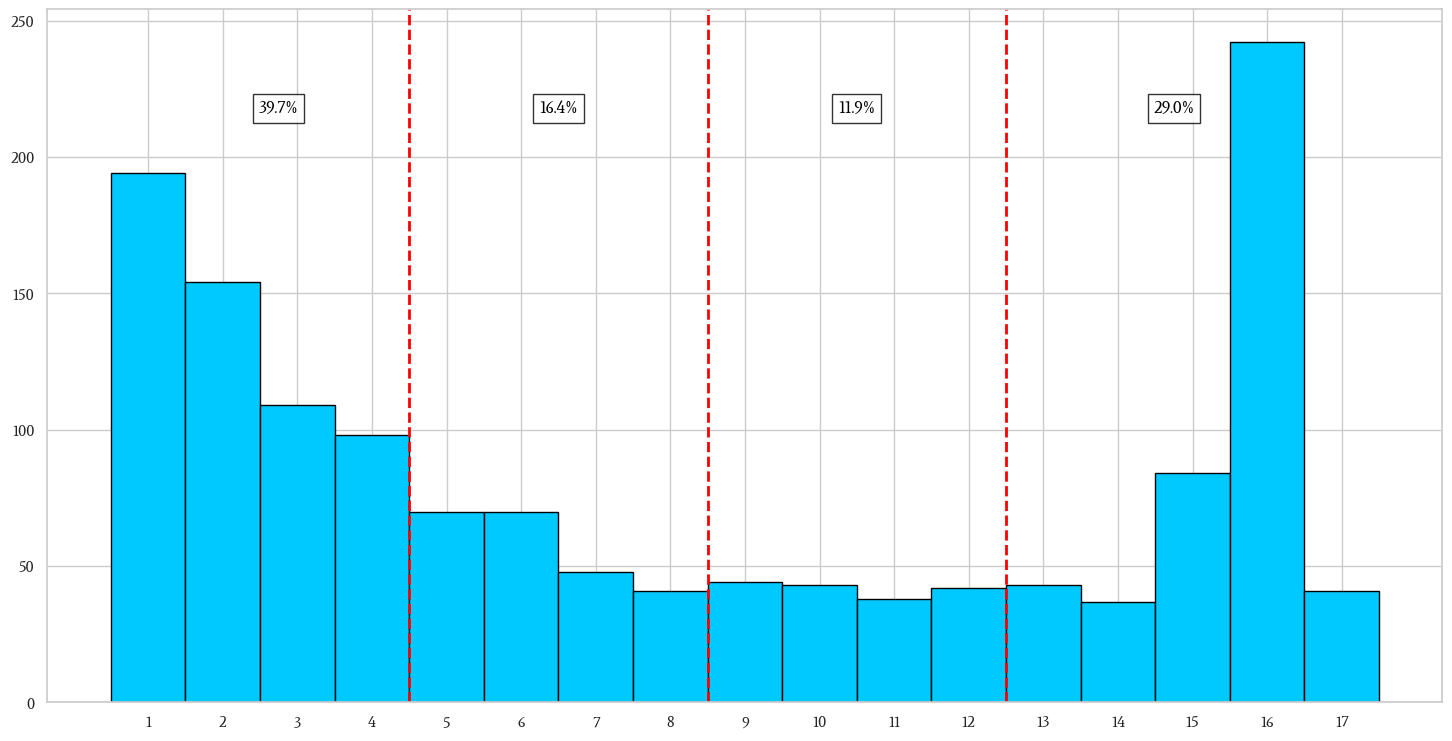

In [8]:
# plot histogram of player_game_count
plot_hist_with_annot(df, 'player_game_count', vertical_lines=[4.5, 8.5, 12.5], color=COLORS[0])

- Only 36% of the rows represent a season where a QB played at least 13 games.
- The other 64% represents seasons in which starting QBs were injured, or just seasons from backup QBs who only play in a few games.

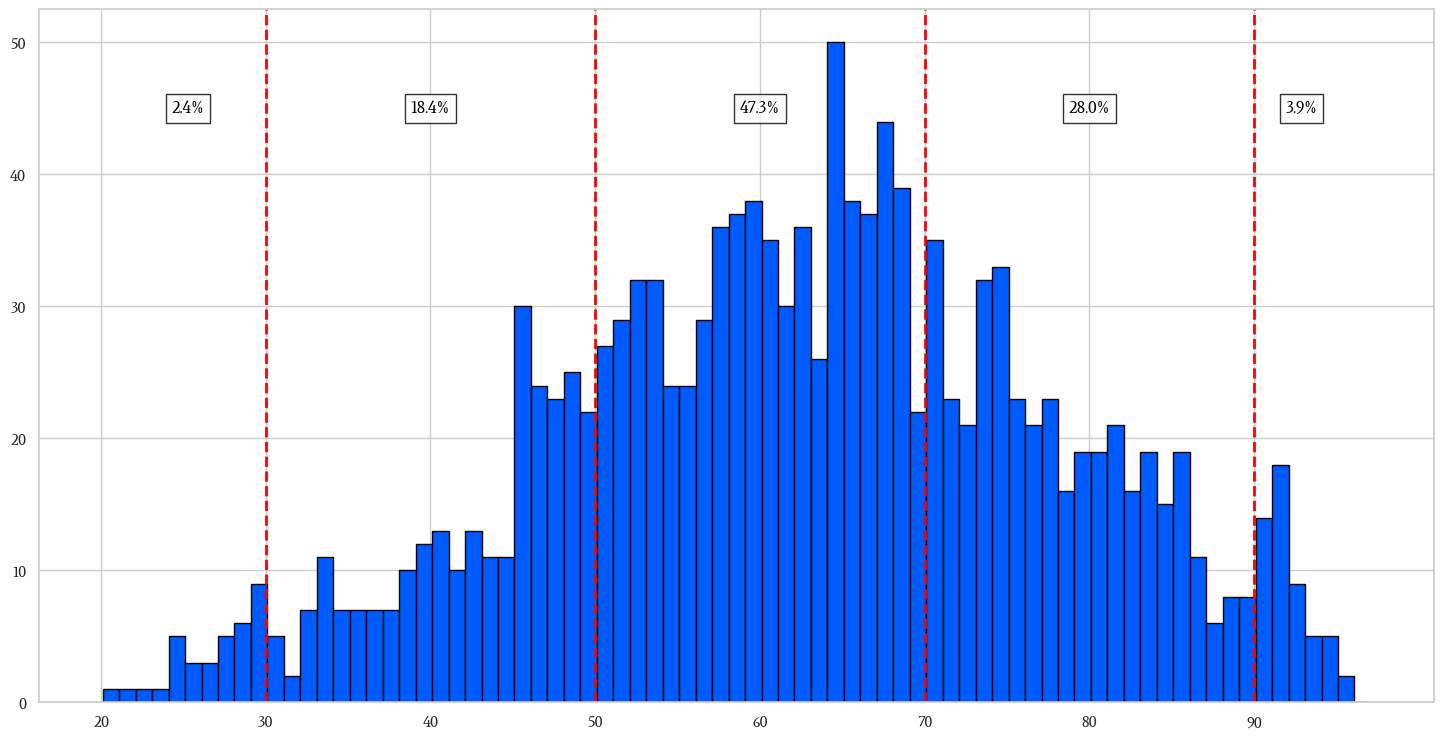

,count,mean,std,min,25%,50%,75%,max
pass_grades_offense,1398.0,62.53176,15.277368,20.6,52.2,63.0,73.475,95.8


In [9]:
# plot histogram of player_game_count
plot_hist_with_annot(df, 'pass_grades_offense', xticklabels=[20 ,30, 40, 50, 60, 70, 80, 90], vertical_lines=[30, 50, 70, 90], color=COLORS[1])

# distribution of offensive grades
df[['pass_grades_offense']].describe().T

- Average offensive grade of 64.
- Only 35% of seasons end with an offensive fgrade north of 70.
- Only 4% end with an elite offensive grade above 90.

,pass_grades_offense,pass_grades_pass,rush_grades_run
pass_grades_offense,1.000000,0.965079,0.267865
pass_grades_pass,0.965079,1.000000,0.149834
rush_grades_run,0.267865,0.149834,1.000000


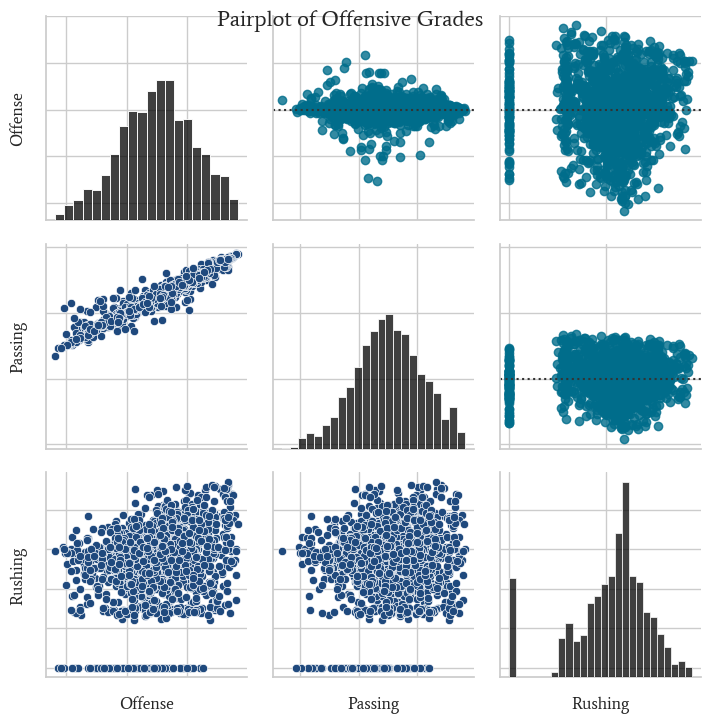

In [10]:
# correlation
display(df[['pass_grades_offense', 'pass_grades_pass', 'rush_grades_run']].corr())

# plot pairplot of grade metrics
plot_pairplot(df)

- Passing grade correlates very strongly with a QB's overall offensive grade (0.97 correlation).
- Rush grade has a much smaller correlation with offensive grade at 0.24. Rush grade correlates even less with passing grade with a correlation of only 0.11.
- This makes sense, as the quarterback position is primarily responsible for passing the football. Although rushing QBs have become more standard in today's league, a QB's ability to pass the football effictively and consistently has a much greater impact on their offensive performance than their rushing capabilities.

# Past Performance
How many seasons prior are useful to predicting a QB's performance in the next season? This analysis will help us in creating features for the modeling process.

In [11]:
# aggregate year groups
df_agg = agg_year_groups(df)

# check
df_agg.query('player == "Joe Burrow"')

,player,year,target,pass_grades_offense,pass_grade_offense_1year_mean,pass_grade_offense_2year_mean,pass_grade_offense_3year_mean,pass_grade_offense_4year_mean,pass_grade_offense_5year_mean,pass_grade_offense_10year_mean,career_pass_grade_offense_mean
659,Joe Burrow,2020,91.7,75.1,75.1,NaN,NaN,NaN,NaN,NaN,NaN
660,Joe Burrow,2021,90.8,91.7,91.7,83.40,NaN,NaN,NaN,NaN,75.100000
661,Joe Burrow,2022,77.9,90.8,90.8,91.25,85.866667,NaN,NaN,NaN,83.400000
662,Joe Burrow,2023,93.9,77.9,77.9,84.35,86.800000,83.875,NaN,NaN,85.866667
663,Joe Burrow,2024,NaN,93.9,93.9,85.90,87.533333,88.575,85.88,NaN,83.875000


- The aggregation was non-inclusive (using min_periods=n), so if a player did not have the specified number of seasons yet played, the resulting mean calculation was NaN.
- This is useful for the following correlation analysis, as we will only be analyzing those that actually have n seasons played in each mean group.

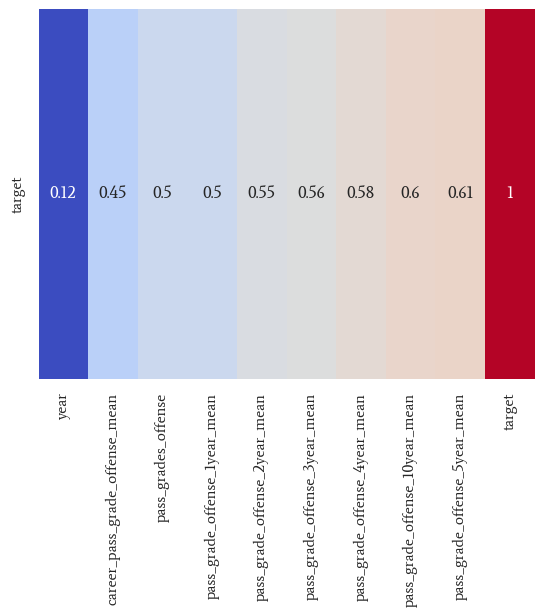

In [12]:
# correlation heatmap
corr_data = df_agg.corr()[['target']].sort_values(by='target', ascending=True).T
sns.heatmap(corr_data, annot=True, cmap='coolwarm', cbar=False);

- 5-year and 10-year means had the strongest correlations.
- I will aggregate each player's stats over their 5 most recent seasons (should capture the 2-4 year groups) and their entire career (should capture the 10-year group).

# Create Features
I will use the mean (capturing peformance) along with the standard deviation (capturing consistency) for each stat.

In [13]:
# exclude specified columns
non_agg_cols = ['player', 'team_name', 'year', 'exp', 'target']
agg_cols = [col for col in df.columns if col not in non_agg_cols]

# add rolling features
df = compute_rolling_stats(df, agg_cols)

# check
display(df.query('player == "Joe Burrow"')[['player', 'year', 'pass_grades_offense', 'pass_grades_offense_5y_mean', 'pass_grades_offense_career_mean']])

,player,year,pass_grades_offense,pass_grades_offense_5y_mean,pass_grades_offense_career_mean
659,Joe Burrow,2020,75.1,75.125,75.125
660,Joe Burrow,2021,91.7,83.375,83.375
661,Joe Burrow,2022,90.8,85.875,85.875
662,Joe Burrow,2023,77.9,83.875,83.875
663,Joe Burrow,2024,93.9,85.875,85.875


In [15]:
# export 2024 data
df_2024 = df[df['year'] == 2024].copy()
df_2024.to_csv('./data/clean/features_2024.csv', index=False)

# drop rows with null target (players in their final season and 2024 season)
df = df.dropna(subset=['target'])

# export data
df.to_csv('./data/clean/features.csv', index=False)